In [1]:
import pandas as pd 
import dataparser 
from  math import log
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from dataparser import *

import folium

pd.set_option('display.max_columns', None)
data=pd.read_csv('_data.csv', index_col=1)

#если цена не в рублях то выбрасываем, цены на доллар и евро сильно меняются, непонятно какая цена в рублях (там всего 27 вариантов)
data=data[data['Цена'].str.contains('руб.')].reset_index()

#убираем всех не из Москвы
data=data[data['Адрес'].str.contains('Москва')].reset_index()

#заполняем пустые места для количества комнат, так как это студии, 1 комната
#фича "Тип" у всех одинаковая, дропаем
data=data.fillna({'Количество комнат':1})\
        .drop('Тип',axis=1)



data_orig=data.copy()


In [2]:
printdata=False

In [3]:
if printdata: data.head(10);

In [4]:
def get_col_room(data):
    # Функция для извлечения количества комнат
    return data['Количество комнат'].astype(str).apply(lambda x: int(x[0]))
data['col_rooms'] = get_col_room(data)
if printdata: data.head(10);

In [5]:
def get_price(data):
    # Функция для извлечения цены
    return data['Цена'].astype(str).apply(lambda x: float(splbac(x,'руб./')[0]))

data['price'] = get_price(data)
if printdata: data.head(10);

In [6]:
def get_ceiling_height(data):
    # Функция для извлечения высоты потолков
    return data['Высота потолков, м'].astype(str).apply(lambda x: float(x.split()[0]))

data['ceiling_height'] = get_ceiling_height(data)
if printdata: data.head(10);

In [7]:
def get_var_room_lamb(s):
    # Вспомогательная функция для извлечения варианта комнат
    if ',' in s:
        return s.split(',')[1][1:]

def get_var_room(data):
    # Функция для извлечения варианта комнат
    return data['Количество комнат'].astype(str).apply(get_var_room_lamb)

data['var_room'] = get_var_room(data)
if printdata: data.head(10);

In [8]:
data['metro'] = get_metro(data)

def get_metro_lamb(s):
    # Вспомогательная функция для извлечения метро
    return splfb(s,'м.','(').strip() if s is not None else None

def get_metro(data):
    # Функция для извлечения метро
    return data['Метро'].astype(str).apply(get_metro_lamb)

if printdata: data.head(10);

In [9]:

def get_metro_time_lamb(s):
    # Вспомогательная функция для извлечения времени до метро
    try:
        if 'пешком'in s:
            return float(splfb(s,'(',' мин').strip() if 'None' not in s else 0)*3 if s is not None or 'nan' else None
        else :
            return float(splfb(s,'(',' мин').strip() if 'None' not in s else 0) if s is not None or 'nan' else None
    except:
        pass

def get_metro_time(data):
    # Функция для извлечения времени до метро
    return data['Метро'].astype(str).apply(get_metro_time_lamb)

data['metro_time'] = get_metro_time(data)
if printdata: data.head(10);

In [10]:
def get_adress_lamb(s):
    # Вспомогательная функция для извлечения адреса
    return s.split(',')[1]

def get_adress(data):
    # Функция для извлечения адреса
    return data['Адрес'].astype(str).apply(get_adress_lamb)


data['adress'] = get_adress(data)
if printdata: data.head(10);

In [11]:
def get_area_lamb(s):
    # Вспомогательная функция для извлечения площади
    if '/'in s:
        return float(splbac(s,'/')[0])
    else:
        return float(s)

def get_area(data):
    # Функция для извлечения площади
    return data['Площадь, м2'].astype(str).apply(get_area_lamb)

data['full_area'] = get_area(data)
if printdata: data.head(10);

In [12]:
def get_kitchen_area_lamb(s):
    # Вспомогательная функция для извлечения площади кухни
    try:
        if len(s.split('/')) == 2:
            return float(s.split('/')[1])
        
        if len(s.split('/')) == 3:
            return float(s.split('/')[2])
    except:
        print(s.split('/'))

def get_kitchen_area(data):
    # Функция для извлечения площади кухни
    return data['Площадь, м2'].astype(str).apply(get_kitchen_area_lamb)

data['kitchen_area'] = get_kitchen_area(data)
if printdata: data.head(10);

In [13]:

def get_living_area_lamb(s):
    # Вспомогательная функция для извлечения жилой площади
    if len(s.split('/')) == 3:
        return float(s.split('/')[1])

def get_living_area(data):
    # Функция для извлечения жилой площади
    return data['Площадь, м2'].astype(str).apply(get_living_area_lamb)

data['living_area'] = get_living_area(data)
if printdata: data.head(10);

In [14]:
def get_floor_lamb(s):
    # Вспомогательная функция для извлечения этажа
    return float(s.split('/')[0])

def get_floor(data):
    # Функция для извлечения этажа
    return data['Дом'].astype(str).apply(get_floor_lamb)


data['floor'] = get_floor(data)
if printdata: data.head(10);

In [15]:

def get_num_floors_lamb(s):
    # Вспомогательная функция для извлечения количества этажей
    if ',' in s:
        return float(s.split(',')[0].split('/')[1])
    else:
        return float(s.split('/')[1])

def get_num_floors(data):
    # Функция для извлечения количества этажей
    return data['Дом'].astype(str).apply(get_num_floors_lamb)

data['num_floors'] = get_num_floors(data)
if printdata: data.head(10);

In [16]:
data['parking'] = data['Парковка']

if printdata: data.head(10);

In [17]:
def get_prolonged(data):
    # Функция для извлечения признака "Длительный"
    return data['Цена'].apply(lambda x: 'Длительный' if 'Длительный' in x  else '')

data['prolonged'] = get_prolonged(data)
if printdata: data.head(10);

In [18]:
def get_phonenum(data):
    # Функция для извлечения телефона
    v = data['Телефоны'].value_counts()
    return data['Телефоны'].astype(str).apply(lambda x: log(v[x], 2))

data['phone_number'] = get_phonenum(data)
if printdata: data.head(10);

In [19]:
def get_coord_y( data):
    # Функция для  определения координат по адресу

    with open('coordinates', 'rb') as file:
        addrdic = pickle.load(file)

    return  data['adress'].apply(lambda x: addrdic[x][0] if addrdic[x] is not None  else None )

def get_coord_x( data):
    # Функция для  определения координат по адресу

    with open('coordinates', 'rb') as file:
        addrdic = pickle.load(file)
    return  data['adress'].apply(lambda x: addrdic[x][1] if addrdic[x] is not None  else None )

data['coord_y'] = get_coord_x( data).clip(lower=36.74401, upper=38.140841)
data['coord_x'] = get_coord_y( data).clip(lower=55.386254, upper=56.119649)

if printdata: data.head(10);

In [20]:
def check_phrases(element):
    if isinstance(element, float):
        return 0
    if 'Мебель в комнатах' in element and 'Мебель на кухне' in element and 'Ванна' or 'Душ' in element and 'Стиральная машина' in element:
        return 1
    return 0


data['Furnished'] = data['Дополнительно'].apply(check_phrases)

if printdata: data.head(10);

In [21]:
#Обработка колонки "Мусоропровод"
data['garbage_chute'] = data['Мусоропровод'].replace({'Да': 1, 'Нет': 0, np.nan: 0}).astype(int)
if printdata: data.head(10);

/tmp/ipykernel_13766/534596198.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['garbage_chute'] = data['Мусоропровод'].replace({'Да': 1, 'Нет': 0, np.nan: 0}).astype(int)


In [22]:

def process_repair_info(s):
    # Функция для обработки информации о ремонте
    if s == 'Без ремонта':
        return 0
    if pd.isna(s):
        return 1
    elif isinstance(s, str):
        if 'Дизайнерский' in s:
            return 3
        elif 'Евроремонт' in s:
            return 2
        elif 'Косметический' in s:
            return 1


# Применение функций к соответствующим столбцам данных
data['repair'] = data['Ремонт'].apply(process_repair_info)

if printdata: data.head(10);

In [23]:



def process_children_pets_info(s):
    # Функция для обработки информации о детях и животных
    if pd.isna(s):
        return 0
    elif 'Можно с детьми, Можно с животными' in s:
        return 2
    elif 'Можно с детьми' in s:
        return 1
    elif 'Можно с животными' in s:
        return 1
    else:
        return 0



data['child_pet'] = data['Можно с детьми/животными'].apply(process_children_pets_info)
if printdata: data.head(10);

In [24]:
data=get_data(data)

/home/ham/elb/d035/real_estate_EDA/dataparser.py:333: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cdata['garbage_chute'] = data['Мусоропровод'].replace({'Да': 1, 'Нет': 0, np.nan: 0}).astype(int)


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19714 entries, 0 to 19713
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              19714 non-null  int64  
 1   price           19714 non-null  float64
 2   col_rooms       19714 non-null  int64  
 3   ceiling_height  10525 non-null  float64
 4   var_room        7962 non-null   object 
 5   metro           19714 non-null  object 
 6   metro_time      19369 non-null  float64
 7   adress          19714 non-null  object 
 8   full_area       19714 non-null  float64
 9   floor           19714 non-null  float64
 10  num_floors      19714 non-null  float64
 11  prolonged       19714 non-null  object 
 12  phone_number    19714 non-null  float64
 13  coord_y         19603 non-null  float64
 14  coord_x         19603 non-null  float64
 15  Furnished       19714 non-null  int64  
 16  elevator        19714 non-null  int64  
 17  garbage_chute   19714 non-null 

# дальше избавляемся от NaN и выбросов

In [26]:
data.describe()



,ID,price,col_rooms,ceiling_height,metro_time,full_area,floor,num_floors,phone_number,coord_y,coord_x,Furnished,elevator,garbage_chute,repair,balcony_count,windows,bathroom,child_pet
count,1.971400e+04,1.971400e+04,19714.000000,10525.000000,19369.000000,19714.000000,19714.000000,19714.000000,19714.000000,19603.000000,19603.000000,19714.000000,19714.000000,19714.000000,19714.000000,19714.000000,14569.000000,19714.000000,19714.000000
mean,2.671283e+08,8.665113e+04,1.997058,2.992767,26.499561,63.233205,7.518768,14.493710,1.491837,37.596809,55.747505,0.856041,1.578016,0.520189,1.628284,0.371462,1.043792,1.091204,1.058436
std,1.980045e+07,1.281974e+05,1.000122,7.856462,18.957577,46.506217,5.992951,9.065938,1.893646,0.136153,0.097860,0.351057,1.196270,0.499605,0.726413,0.540586,0.576402,0.627334,0.743824
min,1.072986e+08,1.200000e+04,1.000000,1.200000,0.000000,7.000000,-1.000000,1.000000,0.000000,36.904058,55.386254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.712395e+08,3.999925e+04,1.000000,2.640000,12.000000,38.900000,3.000000,9.000000,0.000000,37.516768,55.684848,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
50%,2.739376e+08,5.000000e+04,2.000000,2.640000,24.000000,49.300000,6.000000,12.000000,1.000000,37.594048,55.749035,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
75%,2.746976e+08,7.500000e+04,3.000000,2.800000,36.000000,69.000000,10.000000,17.000000,2.584963,37.676649,55.813428,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000
max,2.750064e+08,3.000000e+06,6.000000,320.000000,357.000000,811.000000,85.000000,116.000000,7.977280,38.140841,55.996423,1.000000,8.000000,1.000000,3.000000,4.000000,2.000000,6.000000,2.000000


In [35]:
data['ceiling_height']=data['ceiling_height'].fillna(3).clip(2.65, 6)
data

,ID,price,col_rooms,ceiling_height,var_room,metro,metro_time,adress,full_area,floor,num_floors,prolonged,phone_number,coord_y,coord_x,Furnished,elevator,garbage_chute,repair,balcony_count,windows,bathroom,child_pet
0,271271157,500000.0,4,3.00,Не указано,Смоленская,4.754888,улица Новый Арбат,200.0,5.0,16.0,Длительный,3.700440,37.601065,55.752996,1,5,1,3,1,0.0,1,2
1,271634126,500000.0,4,3.50,Не указано,Смоленская,4.584963,улица Новый Арбат,198.0,5.0,16.0,Длительный,4.087463,37.601065,55.752996,1,2,0,3,1,2.0,3,1
2,271173086,500000.0,4,3.20,Оба варианта,Смоленская,4.392317,улица Новый Арбат,200.0,5.0,16.0,Длительный,3.459432,37.601065,55.752996,1,1,0,2,1,2.0,3,1
3,272197456,400000.0,4,3.20,Оба варианта,Смоленская,3.169925,переулок Плотников,170.0,5.0,6.0,Длительный,3.321928,37.588459,55.746600,1,1,0,2,1,2.0,3,1
4,273614615,225000.0,2,3.90,Не указано,Арбатская,4.392317,улица Новый Арбат,58.0,12.0,26.0,Длительный,4.523562,37.601065,55.752996,1,2,1,2,1,2.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19709,215565511,42000.0,1,3.00,Не указано,Говорово,4.584963,Боровское шоссе,35.0,10.0,14.0,Длительный,0.000000,37.370423,55.647751,1,2,0,2,1,0.0,1,0
19710,274654844,45000.0,1,3.00,Не указано,Солнцево,4.392317,Производственная улица,38.7,5.0,18.0,Длительный,0.000000,37.118064,55.587787,1,2,0,2,0,1.0,1,0
19711,268679909,50000.0,2,3.00,Оба варианта,Солнцево,4.169925,Боровский проезд,43.1,5.0,5.0,Длительный,0.000000,37.390800,55.654882,1,0,0,3,1,2.0,1,1
19712,274807525,55000.0,2,2.65,Не указано,Солнцево,5.044394,улица Богданова,52.5,8.0,23.0,Длительный,0.000000,37.398719,55.655718,1,3,1,2,1,1.0,2,0


In [34]:
data['windows']=data['windows'].fillna(0)

In [28]:
print(data['elevator'].unique())
data.loc[(data['elevator']==0) & (data['num_floors']>5)& (data['num_floors']<14),'elevator']=1
data.loc[(data['elevator']==0) & (data['num_floors']>13),'elevator']=2
data['elevator']=data['elevator']

[5 2 1 0 3 4 6 8 7]


In [29]:
print(data['balcony_count'].unique())
data.loc[(data['balcony_count']==0)& (data['full_area']>50),'balcony_count']=1
data['elevator']=data['elevator']

[0 1 3 2 4]


In [30]:
print(data['bathroom'].unique())
data.loc[data['bathroom'] == 0,'bathroom'] = 1

[0 3 2 1 4 6 5]


In [31]:
data['var_room']=data['var_room'].fillna('Не указано')
print(data['var_room'].unique())


['Не указано' 'Оба варианта' 'Изолированная' 'Смежная']


In [32]:
data['metro_time']=data['metro_time'].fillna(30).replace(0,1).apply(lambda x: log(x,2))


In [33]:
data['living_area']=data['full_area']-data['kitchen_area']

KeyError: 'kitchen_area'

In [ ]:
data
 






,ID,price,col_rooms,ceiling_height,var_room,metro,metro_time,adress,full_area,floor,num_floors,prolonged,phone_number,coord_y,coord_x,Furnished,elevator,garbage_chute,repair,balcony_count,windows,bathroom,child_pet
0,271271157,500000.0,4,3.00,Не указано,Смоленская,4.754888,улица Новый Арбат,200.0,5.0,16.0,Длительный,3.700440,37.601065,55.752996,1,5,1,3,1,NaN,1,2
1,271634126,500000.0,4,3.50,Не указано,Смоленская,4.584963,улица Новый Арбат,198.0,5.0,16.0,Длительный,4.087463,37.601065,55.752996,1,2,0,3,1,2.0,3,1
2,271173086,500000.0,4,3.20,Оба варианта,Смоленская,4.392317,улица Новый Арбат,200.0,5.0,16.0,Длительный,3.459432,37.601065,55.752996,1,1,0,2,1,2.0,3,1
3,272197456,400000.0,4,3.20,Оба варианта,Смоленская,3.169925,переулок Плотников,170.0,5.0,6.0,Длительный,3.321928,37.588459,55.746600,1,1,0,2,1,2.0,3,1
4,273614615,225000.0,2,3.90,Не указано,Арбатская,4.392317,улица Новый Арбат,58.0,12.0,26.0,Длительный,4.523562,37.601065,55.752996,1,2,1,2,1,2.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19709,215565511,42000.0,1,3.00,Не указано,Говорово,4.584963,Боровское шоссе,35.0,10.0,14.0,Длительный,0.000000,37.370423,55.647751,1,2,0,2,1,NaN,1,0
19710,274654844,45000.0,1,3.00,Не указано,Солнцево,4.392317,Производственная улица,38.7,5.0,18.0,Длительный,0.000000,37.118064,55.587787,1,2,0,2,0,1.0,1,0
19711,268679909,50000.0,2,3.00,Оба варианта,Солнцево,4.169925,Боровский проезд,43.1,5.0,5.0,Длительный,0.000000,37.390800,55.654882,1,0,0,3,1,2.0,1,1
19712,274807525,55000.0,2,2.65,Не указано,Солнцево,5.044394,улица Богданова,52.5,8.0,23.0,Длительный,0.000000,37.398719,55.655718,1,3,1,2,1,1.0,2,0


<Axes: xlabel='price', ylabel='metro_time'>

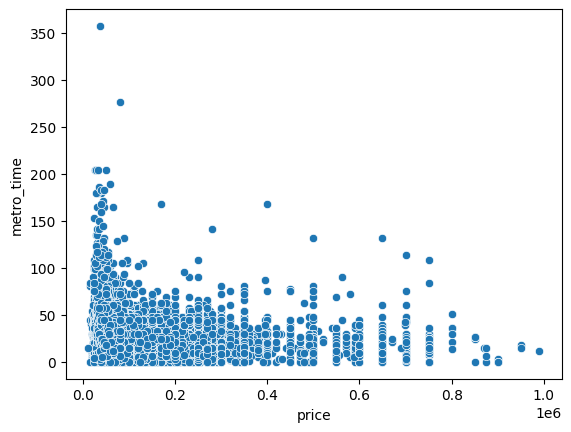

In [ ]:
data=data[data['price']<1000000]
sns.scatterplot(data,x='price',y='metro_time')

In [ ]:
#для получения координат по адресам
assert False

from geopy.geocoders import Nominatim
addarr= data['adress']
addrdic={}

def get_metro_station_coordinates(station_name):
    geolocator = Nominatim(user_agent="metro_locator")  

    # Добавим "метро" к запросу для более точного результата
    location = geolocator.geocode(f"{station_name} , Москва")

    if location:
        coordinates = (location.latitude, location.longitude)
        return coordinates
    else:
        print(f"Координаты для станции метро {station_name} не найдены.")
        return None

for i in addarr:
    try:
        if i in addrdic.keys():
            continue
        addrdic[i] = get_metro_station_coordinates(i)
    except:
        pass

with open('coordinates', 'wb') as file:
    pickle.dump(addrdic, file)



AssertionError: 